# Short-list promising models  

We will try the following models:
- Random Forest
- Neural Networks

Obviously, these searches for a promising models could be much more elaborative, but the idea is to showcase the basic models non linear models, include working with tensorflow and scikit-learn as well as cross-validation. So far it seems that Random Forest is a better fit. NNs are in a separate jupyter notebook - __model_building_nn__. Basically, there is a ton of possibilities to improve the NN model, such as tailormake the NN architecture, drop out some neurons, go deeper into the deep learning, etc. Since this is at a stage where other parts of this project need more attention and the result with RF is already satisfying, I will come back to this to explore other methods, such as a promising new "Cat Boost" library from Yandex, or improve the possible architectures of NN, etc., when I come up with an adequate test coverage for the deployed model. 

### Note: I cannot push more than 100MB into Github, while PyPi can recieve a maximum of just 60 MB files, thus, this hyperparameter tuning is going to be degraded once it goes into the model.

# TLDR comparison of 3 methods from 2 notebooks:
- 3000 trees RF hyperparameter tuned
- 300 trees RF with same hyperparameters
- Generic 300-200-100 3 hidden layers NN architecture from the other notebook

|      | 3000 trees RF | 300 trees RF | 300-200-100 NN |
|:----:|:-------------:|:------------:|:--------------:|
|  mse |     0.0637    |    0.0643    |     0.0791     |
| rmse |     0.2524    |    0.2536    |     0.2813     |
|  r2  |     0.9353    |    0.9347    |     0.9197     |

As a result, 500 trees RF was selected. Hyperparameters, fit, distribution of errors and feature importances are available below in the notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pytz
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [2]:
X_train = pd.read_csv('../datasets/scaled_train_test/X_train_standard.csv', delimiter=',')
X_test = pd.read_csv('../datasets/scaled_train_test/X_test_standard.csv', delimiter=',')
y_train = X_train['Value (kWh)']
y_test = X_test['Value (kWh)']
X_train.drop(['Value (kWh)'], axis=1, inplace=True)
X_test.drop(['Value (kWh)'], axis=1, inplace=True)

We will split the X_train data further into X_train and X_val, which is going to be our validation set.

In [3]:
from sklearn.model_selection import train_test_split
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.8) 

In [4]:
X_train_v.columns

Index(['Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Wind speed (m/s)', 'Global radiation (W/m2)', 'Wind_direction',
       'Cloud_amount_binary', 'Precipitation_binary', 'hour_of_day',
       'day_of_year', 'solar_elev_angle', 'sun_azimuth',
       'TheoreticalSolarRadiation'],
      dtype='object')

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter tuning for Random Forest

In [8]:
rf = RandomForestRegressor()

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pprint import pprint
#source code: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [1000,2000,3000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [10]:
max_depth

[10, 20, 30, None]

In [11]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 6)

In [12]:
rf_random.fit(X_train_v, y_train_v)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed: 27.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [13]:
rf_random.best_params_

{'n_estimators': 3000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [14]:
rf_best_param = rf_random.best_params_

In [15]:
import pickle
pickle.dump(rf_best_param, open( "rf_best_param_CV.p", "wb" ) )

In [6]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    print('Model Performance')
    print('mse: {}'.format(mean_squared_error(y, y_pred)))
    print('rmse: {}'.format(sqrt(mean_squared_error(y, y_pred))))
    print('r2: {}'.format(r2_score(y, y_pred)))

In [7]:
rf = RandomForestRegressor(n_estimators=3000,
 min_samples_split= 5,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 30,
 bootstrap= False,
 n_jobs=-1, 
 random_state=42)

In [8]:
rf.fit(X_train_v, y_train_v)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=3000, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Evaluation on training data

In [9]:
evaluate(rf,X_train_v,y_train_v)

Model Performance
mse: 0.0019102114747468059
rmse: 0.043705966123022674
r2: 0.9980965968193543


Evaluation on validation data

In [10]:
evaluate(rf, X_val, y_val)

Model Performance
mse: 0.06334051346510983
rmse: 0.25167541291335915
r2: 0.9366020743000056


Evaluation on test data

In [11]:
evaluate(rf, X_test, y_test)

Model Performance
mse: 0.0637442599594437
rmse: 0.25247625622906344
r2: 0.9353805128620167


Text(0.5, 1.0, 'Evaluation of Random Forest Predictions')

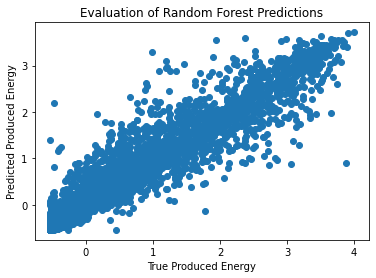

In [12]:
plt.scatter(y_test, rf.predict(X_test))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Random Forest Predictions')

Text(0.5, 1.0, 'Error distribution')

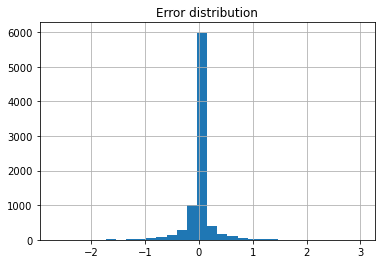

In [13]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - rf.predict(X_test)
errors.hist(bins=30)
plt.title('Error distribution')

Feature importances:  [0.00770888 0.07690024 0.04712275 0.01067861 0.00625648 0.33462002
 0.00773389 0.02464813 0.00194762 0.04271398 0.01299678 0.10570291
 0.04668671 0.27428303]


Text(0.5, 1.0, 'Feature importances')

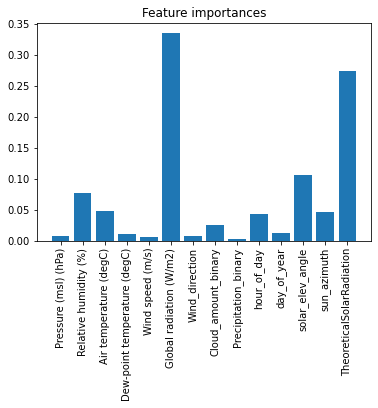

In [14]:
print("Feature importances: ", rf.feature_importances_)
plt.bar(x=X_train.columns,height=rf.feature_importances_);
plt.xticks(rotation='vertical');
plt.title('Feature importances')

Because Github has around a 100MB as the maximum allowed file size to be uploaded and we do not have our python package as a private repository on an index server, we will use the following compression (such as below) of our .pkl file with joblib.

In [36]:
import joblib
joblib.dump(rf, 'test_random_forest_no_compress.pkl', compress=3)

['test_random_forest_no_compress.pkl']

The file size with current compression tunes down to 350MB with the pipeline. This is too large for Github, we will have to degrade the model, perhaps with less trees and see if that would work and yield satisfactory results. In real life scenario, it is possible to use plenty of tools to deploy larger files with quite a small induced cost. This project is done with free tools, though.

# Compressing the model size by reducing the number of trees

In [7]:
rf = RandomForestRegressor(n_estimators=300,
 min_samples_split= 5,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 30,
 bootstrap= False,
 n_jobs=-1, 
 random_state=42)

In [8]:
rf.fit(X_train_v, y_train_v)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Evaluation on training data

In [9]:
evaluate(rf,X_train_v,y_train_v)

Model Performance
mse: 0.0019076944726534376
rmse: 0.04367716191161506
r2: 0.9980991048504564


Evaluation on validation data

In [10]:
evaluate(rf, X_val, y_val)

Model Performance
mse: 0.06361261802864059
rmse: 0.25221541988673213
r2: 0.9363297230992083


Evaluation on test data

In [11]:
evaluate(rf, X_test, y_test)

Model Performance
mse: 0.06434416338278723
rmse: 0.25366151340474813
r2: 0.9347723725906661


Text(0.5, 1.0, 'Evaluation of Random Forest Predictions')

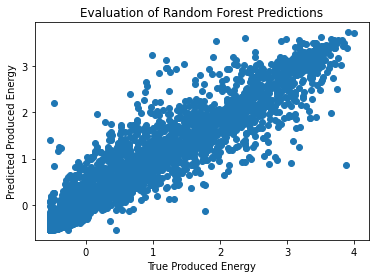

In [12]:
plt.scatter(y_test, rf.predict(X_test))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Random Forest Predictions')

Text(0.5, 1.0, 'Error distribution')

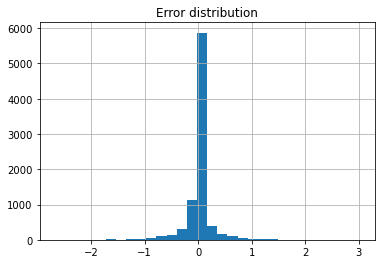

In [13]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - rf.predict(X_test)
errors.hist(bins=30)
plt.title('Error distribution')

Feature importances:  [0.00765017 0.0802961  0.04350556 0.00963792 0.00620005 0.32798933
 0.00826406 0.02410791 0.00169038 0.03572784 0.01114994 0.1054925
 0.04880031 0.28948792]


Text(0.5, 1.0, 'Feature importances')

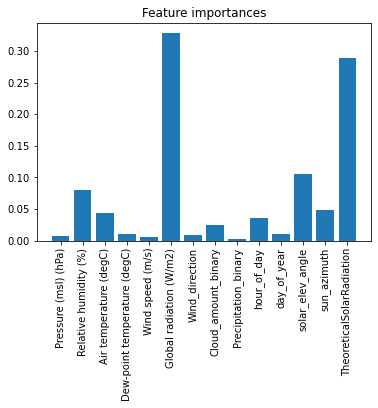

In [14]:
print("Feature importances: ", rf.feature_importances_)
plt.bar(x=X_train.columns,height=rf.feature_importances_);
plt.xticks(rotation='vertical');
plt.title('Feature importances')

# Comparison of methods: 

I will also place this table in the header of the notebook

- 3000 trees RF hyperparameter tuned
- 300 trees RF with same hyperparameters
- Generic 300-200-100 3 hidden layers NN architecture from the other notebook

|      | 3000 trees RF | 300 trees RF | 300-200-100 NN |
|:----:|:-------------:|:------------:|:--------------:|
|  mse |     0.0637    |    0.0643    |     0.0791     |
| rmse |     0.2524    |    0.2536    |     0.2813     |
|  r2  |     0.9353    |    0.9347    |     0.9197     |